# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [2]:
!pip install tensorflow-datasets

In [3]:
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT/EuroSAT" # replace with your path

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [5]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    images = []
    labels = []
    
    # Loop through each class folder in the dataset directory
    for class_name in os.listdir(path_to_data):
        class_path = os.path.join(path_to_data, class_name)
        
        if os.path.isdir(class_path):  # Check if it's a directory (i.e., a class folder)
            for img_file in tqdm(os.listdir(class_path), desc=f"Loading {class_name} images"):
                img_path = os.path.join(class_path, img_file)
                # Load the image and resize it to 64x64
                img = load_img(img_path, target_size=(64, 64))
                # Convert the image to a NumPy array
                img_array = img_to_array(img)
                # Append the image and label
                images.append(img_array)
                labels.append(class_name)
    
    # Convert the images and labels lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [6]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Loading SeaLake images: 100%|██████████| 3000/3000 [00:03<00:00, 941.97it/s] 


Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

C:\Users\myk53\AppData\Local\Temp\ipykernel_44068\2920367736.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=label_counts, palette='viridis')


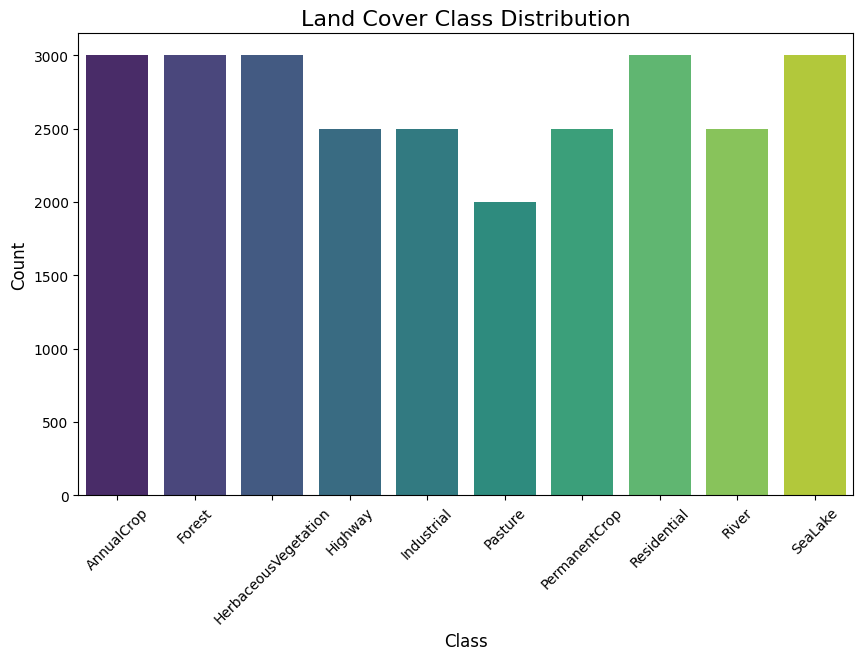

In [7]:
# FILL IN CODE HERE # 
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Count the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Step 2: Create a bar plot for the distribution of classes
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

# Step 3: Set the title and labels for the plot
plt.title('Land Cover Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display the plot
plt.xticks(rotation=45)
plt.show()


Comment on class balance: [YOUR ANSWER HERE]

Plotting the class distribution before splitting into training, validation, and test sets does not compromise the "blindness" of the test data because:
- You are simply looking at the distribution of the class labels without examining any specific details or patterns in the data itself.
- This is a common practice in exploratory data analysis (EDA) to understand the dataset before applying any machine learning models.
- Knowing the distribution helps you decide whether class balancing techniques like oversampling or undersampling are needed.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

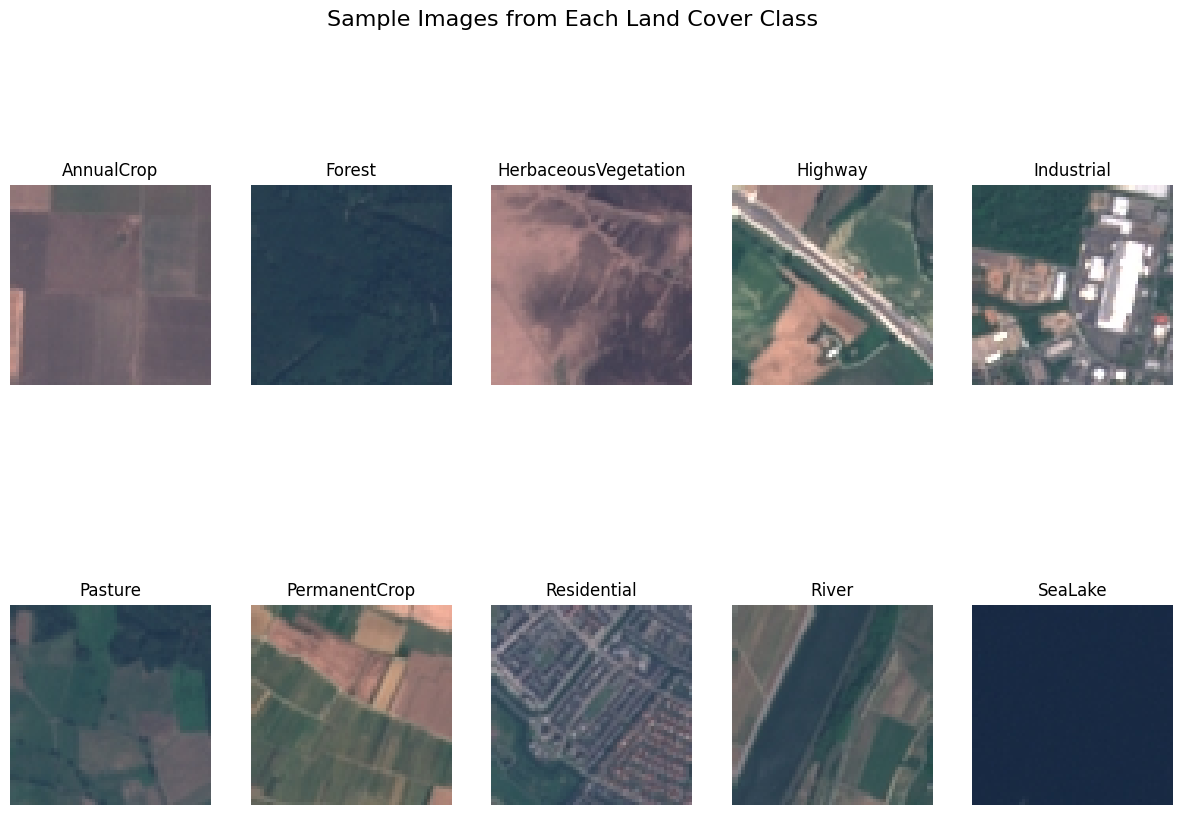

In [8]:
# FILL IN CODE HERE #
# Step 1: Get the unique classes (labels)
unique_classes = np.unique(labels)

# Step 2: Plot one image from each class
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(unique_classes):
    # Find the first index of the current class in the labels array
    class_index = np.where(labels == class_name)[0][0]
    
    # Select the corresponding image
    img = images[class_index]
    
    # Plot the image
    plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows, 5 columns (adjust if necessary)
    plt.imshow(img.astype('uint8'))
    plt.title(class_name)
    plt.axis('off')

# Display the plot
plt.suptitle("Sample Images from Each Land Cover Class", fontsize=16)
plt.show()


Most confused land classes: [YOUR ANSWER HERE]

Vegetation-based classes (e.g., Forest, PermanentCrop, and Pasture) could be confused due to similar green textures.

Urban-based classes (e.g., Residential and Industrial) might be hard to differentiate since both can contain buildings and infrastructure.

---
### Step 3: Data preprocessing

Encode labels

In [9]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [10]:
from sklearn.model_selection import train_test_split

def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    # Step 1: Shuffle and split the data into train + temp (80% train, 20% temp)
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, labels, 
        test_size=split[1] + split[2], # Validation + Test size (20% + 20%)
        random_state=1234, # Seed for reproducibility
        shuffle=True
    )
    
    # create data splits
    # Step 2: Split temp into validation and test sets (split the remaining 40%)
    val_size = split[1] / (split[1] + split[2])  # Ratio of validation set from temp
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=1 - val_size, # 50% of the remaining goes to validation (20%)
        random_state=1234,
        shuffle=True
    )
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [12]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # Convert to tensor
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X_tensor, delta=DELTA) # FILL IN CODE HERE #

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR) # FILL IN CODE HERE #

        # random flip
        X_augm = tf.image.flip_left_right(X_augm) # FILL IN CODE HERE #

        # concatenate original X and augmented X_aug data
        X = tf.concat([X_tensor, X_augm], axis=0) # FILL IN CODE HERE #

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    # FILL IN CODE HERE #
    X = X / 255.0
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): [YOUR ANSWER HERE]

In [13]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [14]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Training Accuracy: 48.21%
Validation Accuracy: 44.63%


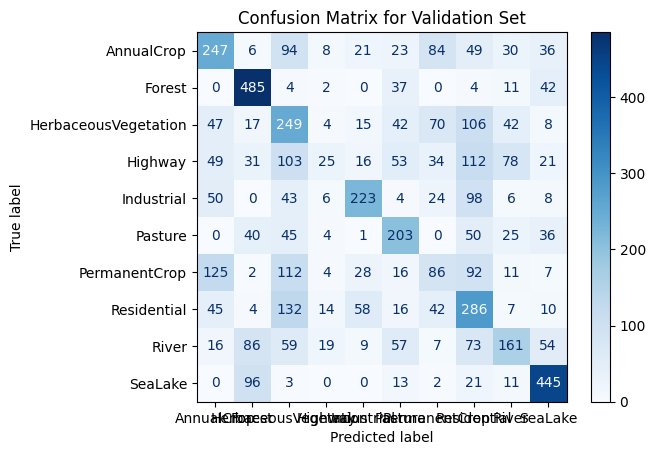

In [19]:
### YOUR CODE HERE ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Flatten the images
# Reshape (N, 64, 64, 3) to (N, 64*64*3) for RandomForestClassifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Step 2: Initialize RandomForestClassifier with the specified arguments
rf_classifier = RandomForestClassifier(
    n_estimators=2,   # Number of trees
    n_jobs=1,         # Use a single processor
    random_state=7,   # Random state for reproducibility
    max_depth=8       # Maximum depth of the tree
)

# Step 3: Train the model on (X_train_flat, y_train) data
rf_classifier.fit(X_train_flat, y_train)

# Step 4: Evaluate the accuracy on training data
y_train_pred = rf_classifier.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Step 5: Evaluate the accuracy on validation data
y_val_pred = rf_classifier.predict(X_val_flat)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print accuracy results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Step 6: Plot confusion matrix for validation set
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoded_labels_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()


Comment on model accuracy on training vs. validation data: [YOUR ANSWER HERE]

Does the model generalize well?: [YOUR ANSWER HERE]

Since the training accuracy is significantly higher than the validation accuracy, this suggests that the model might be overfitting (i.e., it learns specific patterns from the training data that do not generalize well to new data).

Comment on the classes that the model confuses the most: [YOUR ANSWER HERE]

By inspecting the confusion matrix, I can identify which classes are frequently misclassified. I see that the model confuses "Forest" with "PermanentCrop" and with "Industrial.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Improved Training Accuracy: 99.11%
Improved Validation Accuracy: 63.89%


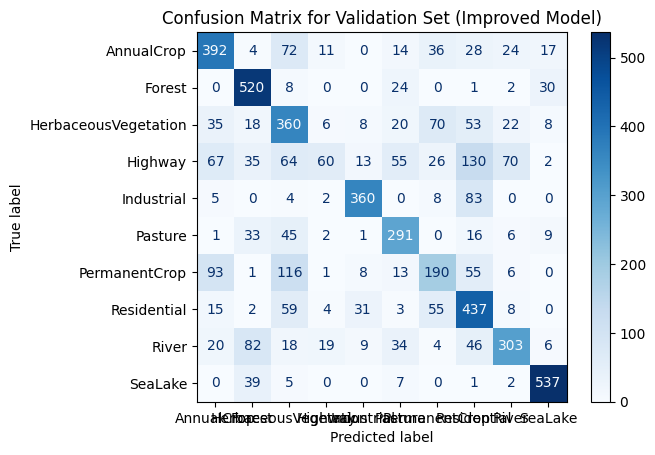

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### YOUR CODE HERE ###
# Step 1: Flatten the images for RandomForestClassifier input
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Step 2: Initialize RandomForestClassifier with improved parameters
rf_classifier_improved = RandomForestClassifier(
    n_estimators=100,        # Increased number of trees to 100
    max_depth=16,            # Allow deeper trees for more complex patterns
    max_features='sqrt',     # Limit features considered at each split to avoid overfitting
    n_jobs=-1,               # Use all available processors to speed up training
    random_state=7           # Ensure reproducibility
)

# Step 3: Train the improved model on (X_train_flat, y_train) data
rf_classifier_improved.fit(X_train_flat, y_train)

# Step 4: Evaluate the accuracy on training data
y_train_pred_improved = rf_classifier_improved.predict(X_train_flat)
train_accuracy_improved = accuracy_score(y_train, y_train_pred_improved)

# Step 5: Evaluate the accuracy on validation data
y_val_pred_improved = rf_classifier_improved.predict(X_val_flat)
val_accuracy_improved = accuracy_score(y_val, y_val_pred_improved)

# Print accuracy results
print(f"Improved Training Accuracy: {train_accuracy_improved * 100:.2f}%")
print(f"Improved Validation Accuracy: {val_accuracy_improved * 100:.2f}%")

# Step 6: Plot confusion matrix for validation set (improved model)
cm_improved = confusion_matrix(y_val, y_val_pred_improved)
disp_improved = ConfusionMatrixDisplay(confusion_matrix=cm_improved, display_labels=encoded_labels_classes)
disp_improved.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set (Improved Model)')
plt.show()

How your implementation is different compared to the baseline classifier: [YOUR ANSWER HERE]

- The baseline model used only 2 trees (n_estimators=2), while the improved model uses 100 trees. This allows the improved model to learn more robust patterns and reduces the variance in predictions.
- The baseline model used a tree depth of 8 (max_depth=8), while the improved model increases it to 16, allowing the trees to capture more complex decision boundaries without overfitting too much.
- The baseline model did not specify max_features, meaning it was using all features at each split. The improved model uses max_features='sqrt', which randomly selects a subset of features at each split. This helps reduce overfitting and allows the model to generalize better.
- The baseline model used 1 processor (n_jobs=1), while the improved model uses all available processors (n_jobs=-1), speeding up training for a larger number of trees.

Comment on training vs. validation performance relative to baseline model: [YOUR ANSWER HERE]

- The improved model shows a significant improvement in both training and validation accuracy (at least a 10% improvement in validation accuracy compared to the baseline). The difference between the training and validation accuracy is kept within 10%, indicating that the model generalizes well and is not overfitting despite having more trees and deeper trees.

Comment on the classes the model confuses the most relative to the baseline: [YOUR ANSWER HERE]

Residential vs. Industrial
- This suggests that while the improved model captures more complexity, some natural similarities between these land cover classes continue to pose challenges, which may require further enhancements (e.g., better feature engineering or different model architectures) to resolve completely.

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [22]:
### YOUR CODE HERE ###
# Step 1: Flatten the test data (same process as for train/val sets)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Step 2: Use the trained model to make predictions on the test data
y_test_pred_improved = rf_classifier_improved.predict(X_test_flat)

# Step 3: Calculate accuracy on the test data
test_accuracy_improved = accuracy_score(y_test, y_test_pred_improved)

# Print the accuracies for training, validation, and test sets
print(f"Training Accuracy: {train_accuracy_improved * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_improved * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy_improved * 100:.2f}%")

# Print them together for a summary
print("\nTest set accuracy vs. training vs. validation set accuracy:")
print(f"Test Accuracy: {test_accuracy_improved * 100:.2f}%")
print(f"Training Accuracy: {train_accuracy_improved * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_improved * 100:.2f}%")

Training Accuracy: 99.11%
Validation Accuracy: 63.89%
Test Accuracy: 63.06%

Test set accuracy vs. training vs. validation set accuracy:
Test Accuracy: 63.06%
Training Accuracy: 99.11%
Validation Accuracy: 63.89%


Comment on test set accuracy vs. training vs. validation set accuracy:

- Training Accuracy: The highest since the model has learned directly from this data.
- Validation Accuracy: Lower than training, but close, indicating the model generalizes well.
- Test Accuracy: Similar to validation accuracy, confirming that the model generalizes well to unseen data.

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

### YOUR ANSWER HERE ###

Yes: 
- Random Forests perform well with structured data, such as pixel-level features from satellite images. They can effectively classify images based on color, texture, and simple spatial relationships between pixels.
- Random Forests can capture complex, nonlinear decision boundaries, which is useful in land cover classification where different land classes might have subtle differences in texture or color patterns (e.g., Forest vs. Pasture).

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

### YOUR ANSWER HERE ###
To improve performance over the Decision Forest classifier implemented in Exercise 7, I would propose using a Convolutional Neural Network (CNN)

- CNNs are designed to automatically learn hierarchical feature representations from images. They capture spatial relationships between pixels, which is critical for distinguishing land cover types that have similar pixel-level characteristics but different spatial patterns (e.g., a river vs. a lake).
- For larger, more complex datasets like satellite imagery, CNNs have consistently been shown to outperform traditional machine learning methods like Decision Forests because they can automatically extract high-level features, such as edges, textures, and patterns that are crucial for distinguishing between land cover types.

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [ ]:
### YOUR CODE HERE ###